In [5]:
# !open .

In [6]:
# %load neo_quant_backbone.py
# %load neo_quant_backbone.py
# !open .
# %load neo_quant_backbone.py
import pandas as pd
import numpy as np
import requests
import bs4
import time
import datetime
import matplotlib.pyplot as plt
from dateutil import parser
from matplotlib import font_manager, rc
from IPython.display import HTML
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# %matplotlib inline



def make_code(x):
    x = str(x)
    code = '0' * (6-len(x)) + x
    if not code.startswith('A'):
        code = 'A' + code
    return code


def make_code2(x):
    x = str(x)
    return '0' * (6-len(x)) + x

# def get_all_company_info():
#     kospi = pd.read_excel('data/kospi.xls')
#     kosdaq = pd.read_excel('data/kosdaq.xls')
#     kospi['구분'] = '코스피'
#     kosdaq['구분'] = '코스닥'
#     companies = pd.concat([kospi, kosdaq])
#     companies = companies[['구분','종목코드','기업명']]
# #     companies['종목코드'] = companies['종목코드'].apply(modifyCompanyCode)
#     companies = companies.reset_index()
#     return companies

def company_apply_a_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code)
    return companies.set_index(new_index)

def company_apply_no_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code2)
    return companies.set_index(new_index)

def remove_a_from_company_code(company_df):
    code_list = []
    for code in company_df.index:
        code = code.replace('A','')
        code_list.append(code)
    return company_df.set_index(pd.Series(code_list))

def _get_firm_list_existing_in_price_df(firm_list, price_df):
    new_firm_list = []
    for code in firm_list:
        if code in price_df.columns:
            new_firm_list.append(code)
    return new_firm_list

def get_company_data(min_price=0):
    kospi = pd.read_excel('data/kospi.xls')
    kosdaq = pd.read_excel('data/kosdaq.xls')
    kospi['구분'] = '코스피'
    kosdaq['구분'] = '코스닥'
    companies = pd.concat([kospi, kosdaq])
    companies = companies[['종목코드','기업명','구분','업종코드','업종','액면가(원)','상장주식수(주)', '자본금(원)']]
    companies['상장주식수(주)'] = companies['상장주식수(주)'].str.replace(',','').astype(int)
    companies['자본금(원)'] = companies['자본금(원)'].str.replace(',','').astype(int)
    companies['액면가(원)'] = companies['액면가(원)'].str.replace(',','').astype(float)
    companies = companies[companies['액면가(원)'] >= min_price]
    companies['액면가(원)'] = companies['액면가(원)'].astype(int)
    companies = companies.set_index('종목코드')
    companies = company_apply_a_prefix(companies)
    return companies

def get_price_data():
    price_path = r'data/price_data_2013.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
#     price_df.columns = 'A' + price_df.columns 
    return price_df

def get_fs_data():
    fs_path = r'data/fs_data.xlsx'
    return get_finance_data(fs_path)

def get_fr_data():
    fr_path = r'data/fr_data.xlsx'
    return get_finance_data(fr_path)

def get_invest_data():
    invest_path = r'data/invest_data.xlsx'
    return get_finance_data(invest_path)

def get_company_df_from_total_capital(company_df, pct):
    company_df = add_price_info(company_df)
    company_df['시가총액'] = company_df['상장주식수(주)'] * company_df['price']
    return company_df.sort_values(by='시가총액', ascending=False)[:int(len(companies) * pct)]

def load_all_data():
    companies = get_company_data()
    fs_df = get_fs_data()
    fr_df = get_fr_data()
    iv_df = get_invest_data()
    prices = get_price_data()
    return companies, fs_df, fr_df, iv_df, prices 

# 액면가 1000원 이상 회사 리스트 가져와서 코드앞에 A 붙이기
# companies = get_company_info(1000)
# companies = apply_a_type_code(companies)

def filter_company(st_df, companies):
    new_company_list = []
    for num, code in enumerate(st_df.index):
        if code in companies.index:
            new_company_list.append(code)

    return st_df.loc[new_company_list]

# def _get_price_over_list(company_code_list, price_df, check_date=None, min_price = 0):
#     if check_date == None:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
#     else:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[-1]})
#     temp_df = temp_df[temp_df['price'] > min_price]
#     return temp_df.index

def _get_price_over_code_list(company_code_list, price_df, min_price = 0, check_month=None):
    if check_month == None:
        temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    else:
        if check_month in price_df.index:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[check_month].iloc[-1]})
        else:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    temp_df = temp_df[temp_df['price'] > min_price]
    return temp_df.index

def _add_company_info(st_df, company_df):
    return pd.merge(st_df, company_df, how='inner', left_index=True, right_index=True)

def _add_price_info(st_df, price_df):
    temp_df = pd.DataFrame({'price':price_df[st_df.index].iloc[-1]}) 
    return pd.merge(st_df, temp_df, how='outer', left_index=True, right_index=True)

# str 이나 list 를 전달한다.
def _get_company_code_list(company_name_list, company_df):
    code_list = []
    if isinstance(company_name_list, str):
        company_name_list = [company_name_list]
    for company_name in company_name_list:
        for num, name in enumerate(company_df['기업명']):
            if company_name in name:
                code_list.append({'code':company_df.index[num], 'name':name})
    return code_list

def _get_company_code(name, company_df):
    return company_df[company_df['기업명']==name].index[0]

def _get_company_name(company_code, company_df):
    return company_df.loc[company_code]['기업명']

def _show_chart(company_code, price_df, company_df, start_date, end_date, show_market_price=False, name=None):
    if isinstance(company_code, str):
        strategy_price = price_df[company_code][start_date:end_date]
        strategy_df = pd.DataFrame({'price':strategy_price})
        
        plt.figure(figsize=(10, 6))
        if name == None:
            name = _get_company_name(company_code, company_df)
        strategy_df['price'].plot(label=name)
        
        if show_market_price == True:
            if is_kospi(company_code):
                market_name = 'KOSPI'
            else:
                market_name = 'KOSDAQ'
            market_price = price_df[market_name][start_date:end_date]
            market_df = pd.DataFrame({'price':market_price})
            ratio = strategy_df.iloc[0]/market_df.iloc[0]
            market_df = market_df * ratio
            market_df['price'].plot(label=market_name)
        
        plt.legend()
        plt.show() 
    else:
        plt.rc('font', size=20)
        company_code_list = company_code
        strategy_price = price_df[company_code_list][start_date:end_date]
        num_row = int((len(company_code_list)-1)/2)+1
        plt.figure(figsize=(10*4, (num_row)*5))
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        for i, code in enumerate(company_code_list):
            ax = plt.subplot(num_row, 4, i+1)
            name = _get_company_name(code, company_df)
            ax.title.set_text(name + ' (' + str(code) + ')')
            ax.plot(strategy_price.index, strategy_price[code], color='black')

            if show_market_price == True:
                if is_kospi(code):
                    market_name = 'KOSPI'
                else:
                    market_name = 'KOSDAQ'
                market_price = price_df[market_name][start_date:end_date]
                market_df = pd.DataFrame({'price':market_price})
                ratio = strategy_price[code].iloc[0]/market_df.iloc[0]
                market_df = market_df * ratio
                ax.plot(market_df.index, market_df['price'], color='red')
        plt.show()

    
# def _show_chart_by_name(company_name, company_df, price_df, year_duration=1):
#     company_list = _get_company_code_list(company_name, company_df)
#     if len(company_list) == 0:
#         print('no company with name' + company_name)
#         return
#     code = company_list[0]['code']
#     name = company_list[0]['name']
#     _show_chart(code, company_df, price_df, year_duration, name) 
    
def _show_monthly_chart(company_code, company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")
    
    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
#             print(year_month)
            if year_month in price_df.index:
                temp_df = pd.DataFrame(price_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df])

    strategy_df = pd.DataFrame({'price':month_df[company_code]})
    ma3 = strategy_df['price'].rolling(window=3).mean()
    strategy_df['ma3'] = ma3

#     plt.figure(figsize=(10, 6))
    name = _get_company_name(company_code, company_df)
#     strategy_df['price'].plot(label=name)

    plt.figure(figsize=(20, 12))
    
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma3'], color='red', label='ma3')

    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 

    
def _show_multi_chart(company_code_list, price_df, company_df, start_date, end_date):
#     end_date = price_df.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code_list][start_date:end_date]
    num_row = int((len(company_code_list)-1)/2)+1
    plt.figure(figsize=(10, num_row*5))
    for i, code in enumerate(company_code_list):
        ax = plt.subplot(num_row, 4, i+1)
        name = _get_company_name(code, company_df)
        ax.title.set_text(name)
        ax.plot(strategy_price.index, strategy_price[code])
    plt.show()


def _show_detail_chart(company_code, company_df, price_df, year_duration=1, name=None):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
#     strategy_df
    ma5 = strategy_df['price'].rolling(window=5).mean()
    strategy_df['ma5'] = ma5
    ma10 = strategy_df['price'].rolling(window=10).mean()
    strategy_df['ma10'] = ma10
    ma20 = strategy_df['price'].rolling(window=20).mean()
    strategy_df['ma20'] = ma20
    ma60 = strategy_df['price'].rolling(window=60).mean()
    strategy_df['ma60'] = ma60
    ma120 = strategy_df['price'].rolling(window=120).mean()
    strategy_df['ma120'] = ma120
    plt.figure(figsize=(20, 12))
    # strategy_df['price'].plot(label=name)
    if name == None:
        name = company_code
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma5'], color='red', label='ma5')
    plt.plot(strategy_df.index, strategy_df['ma10'], color='blue', label='ma10')
    plt.plot(strategy_df.index, strategy_df['ma20'], color='green', label='ma20')
    plt.plot(strategy_df.index, strategy_df['ma60'], color='cyan', label='ma60')
    plt.plot(strategy_df.index, strategy_df['ma120'], color='yellow', label='ma120')
    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 
    


def _show_detail_chart_by_name(company_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(company_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    _show_detail_chart(code, company_df, price_df, year_duration, name)    
    
    
def _get_maximum_earning_rate(price_df, company_df, year_duration=1, min_price=0, min_profit=0, type='all'):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]
    
    price_diff_df = pd.DataFrame({first_price.name:first_price, last_price.name:last_price})
    price_diff_df = price_diff_df[price_diff_df[last_price.name] > min_price]
    
    price_diff_df['diff'] = price_diff_df[last_price.name] - price_diff_df[first_price.name]
#     price_diff_df = price_diff_df[price_diff_df['diff'] > 0]
    
    # price_diff_df['ratio'] = price_diff_df['diff'] / price_diff_df[first_price.name]
    price_diff_df['ratio'] = ((price_diff_df[last_price.name] / price_diff_df[first_price.name]) - 1) * 100
    price_diff_df['ratio'] = price_diff_df['ratio'].astype(int)
    
    price_diff_df = price_diff_df[price_diff_df['ratio'] > min_profit]
    
    price_diff_df = price_diff_df.sort_values(by='ratio', ascending=False)
    
    price_diff_df = _add_company_info(price_diff_df, company_df)
    
    if type == 'kospi':
        price_diff_df = get_kospi_list(price_diff_df)
    elif type == 'kosdaq':
        price_diff_df = get_kosdaq_list(price_diff_df)
        
    return price_diff_df


def _show_earning_chart(code_list, price_df, year_duration=1, initial_money=100000000):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    st_backtest = _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money)
    plt.figure(figsize=(10, 6))
    st_backtest['total_change_rate'].plot()
    plt.show()
    
def _show_company_info(company_code_list, company_df, price_df):
    firm_df = company_df.loc[company_code_list]
    firm_df = _add_price_info(firm_df, price_df)
    firm_df['fs_info'] = firm_df.index
    firm_df['fs_info'] = firm_df['fs_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode={0}" target="_blank">fs</a>'.format(x))
    firm_df['fr_info'] = firm_df.index
    firm_df['fr_info'] = firm_df['fr_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode={0}" target="_blank">fr</a>'.format(x))
    firm_df['iv_info'] = firm_df.index
    firm_df['iv_info'] = firm_df['iv_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode={0}" target="_blank">iv</a>'.format(x))
    firm_df['chart'] = firm_df.index
    firm_df['chart'] = firm_df['chart'].apply(lambda x: x.replace('A',''))
    firm_df['chart'] = firm_df['chart'].apply(lambda x: '<a href="https://finance.naver.com/item/fchart.nhn?code={0}" target="_blank">chart</a>'.format(x))
    return HTML(firm_df.to_html(escape=False))

def _show_company_info_by_name(firm_name, company_df):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
#     company_list
    code_list = []
    for company in company_list:
        code_list.append(company['code'])
    return _show_company_info(code_list, companies)

def _show_earning_rate(company_code_list, company_df, price_df, year_duration=1):
    company_selected = companies.loc[company_code_list]

    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[company_code_list][start_date:end_date]
    strategy_price = strategy_price.dropna()
    strategy_price = strategy_price.fillna(method='bfill')
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]

    company_selected['profit'] = ((last_price/first_price - 1) * 100).astype(int)
    company_selected['profit'] = company_selected['profit'].astype(str) + ' %'
    return company_selected

def _show_earning_rate_by_name(firm_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        return "No Company with name : " + firm_name
    
    code_list = []
    for company in company_list:
        code_list.append(company['code'])

    return _show_earning_rate(code_list, company_df, price_df, year_duration)


def get_vaild_code_from_price_df(code_list, price_df):
    new_code_list = []
    for code in code_list:
        if code in price_df.columns:
            new_code_list.append(code)
    return new_code_list        

def _show_business_trend(company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    company_df['업종코드'] = company_df['업종코드'].astype(str)
    company_df['업종구분'] = company_df['업종코드'] + ' (' + company_df['업종'] + ')'
    all_busi = company_df['업종구분'].unique()
    busi_list = []
    for busi_name in all_busi:
        temp_list = company_df[company_df['업종구분'] == busi_name]
        busi_list.append({'name':busi_name + ' - ' + str(len(temp_list)),'list':temp_list.index})

    for i, busi in enumerate(busi_list):
        busi_name = busi['name']
        busi_code_list = busi['list']
        strategy_price = price_df[get_vaild_code_from_price_df(busi_code_list, price_df)][start_date:end_date]
        strategy_price.fillna(method='bfill')
        busi_earning = strategy_price.sum(axis=1)
        temp_df = pd.DataFrame({busi_name:busi_earning})
        if i == 0:
            total_busi_earning = temp_df
        else:
            total_busi_earning = pd.merge(total_busi_earning, temp_df, how='outer', left_index=True, right_index=True)
    num_row = int((len(total_busi_earning.columns)-1)/4)+1
    plt.figure(figsize=(6*4, num_row*6))
    for i, busi in enumerate(total_busi_earning.columns):
        ax = plt.subplot(num_row, 4, i+1)
        ax.title.set_text(busi)
        ax.plot(total_busi_earning.index, total_busi_earning[busi])
    plt.show()    
    
def get_company_list_from_business_code(busi_code, company_df):
    return company_df[company_df['업종코드'] == busi_code].index





def fetch_prices(compay_code_list, timeframe, count):
    for num, code in enumerate(compay_code_list):
        try:
            print(num, code)
            time.sleep(1)
            try:
                price_df = make_price_dataframe(code, timeframe, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                price_df = make_price_dataframe(code, timeframe, count)
            if num == 0 :
                total_price = price_df
            else:
                total_price = pd.merge(total_price, price_df, how='outer', right_index=True, left_index=True)
        except ValueError:
            continue
        except KeyError:
            continue
    return total_price





# 기존 price dataframe 을 최신 가격으로 업데이트.
# ex) prices_update = update_prices(companies, prices, '10') 
# 기존 price 와 신규 price 의 차이 비교
# prices_update.merge(prices,indicator = True, left_index=True, right_index=True, how='outer').loc[lambda x : x['_merge']!='both']
def update_origin_price_df(origin_price_df, code, count):
    origin_prices = origin_price_df
    price_df = make_price_dataframe(code, 'day', count)
    price_df.index = pd.to_datetime(price_df.index)
    price_df[code] = price_df[code].astype(float)
    price_df_origin = pd.DataFrame({code:origin_prices[code]}) 
    new_price_df = pd.concat([price_df_origin, price_df])
    new_price_df = new_price_df.loc[~new_price_df.index.duplicated(keep='last')]
    origin_prices = origin_prices.drop(code, axis=1)
    origin_prices = pd.merge(origin_prices, new_price_df, left_index=True, right_index=True, how='outer')
    return origin_prices
    
def update_prices(company_df, origin_price_df, count):
    origin_prices = origin_price_df
    for num, code in enumerate(company_df.index):
        try:
            print(num, code)
            time.sleep(1)
            try:
                origin_prices = update_origin_price_df(origin_prices, code, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                origin_prices = update_origin_price_df(origin_prices, code, count)
        except ValueError:
            continue
        except KeyError:
            continue
    return origin_prices

# [코드 3.15] 재무제표 데이터를 가져와 데이터프레임으로 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fs_dataframe(firm_code):
    fs_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode=' + firm_code
    fs_page = requests.get(fs_url)
    fs_tables = pd.read_html(fs_page.text)
    
    temp_df = fs_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df[temp_df.columns[:4]]
    temp_df = temp_df.loc[['매출액', '영업이익', '당기순이익']]

    temp_df2 = fs_tables[2]
    temp_df2 = temp_df2.set_index(temp_df2.columns[0])
    temp_df2 = temp_df2.loc[['자산', '부채', '자본']]

    temp_df3 = fs_tables[4]
    temp_df3 = temp_df3.set_index(temp_df3.columns[0])
    temp_df3 = temp_df3.loc[['영업활동으로인한현금흐름']]

    fs_df = pd.concat([temp_df, temp_df2, temp_df3])
    
    return fs_df

# [코드 3.19] 데이터프레임 형태 바꾸기 코드 함수화 (CH3. 데이터 수집하기.ipynb)

def change_df(firm_code, dataframe):
    for num, col in enumerate(dataframe.columns):
        temp_df = pd.DataFrame({firm_code : dataframe[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col]*len(dataframe), temp_df.columns]
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df, temp_df, how='outer', left_index=True, right_index=True)    
    
    return total_df

# [코드 3.21] 재무 비율 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fr_dataframe(firm_code):
    fr_url = 'https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode=' + firm_code
    fr_page = requests.get(fr_url)
    fr_tables = pd.read_html(fr_page.text)
    
    temp_df = fr_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['유동비율계산에 참여한 계정 펼치기',
                           '부채비율계산에 참여한 계정 펼치기',
                           '영업이익증가율계산에 참여한 계정 펼치기',
                           'ROA계산에 참여한 계정 펼치기',
                           'ROIC계산에 참여한 계정 펼치기']]
    temp_df.index = ['유동비율', '부채비율', '영업이익률', 'ROA', 'ROIC']
    return temp_df

# [코드 3.23] 투자지표 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_invest_dataframe(firm_code):
    invest_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode=' + firm_code
    invest_page = requests.get(invest_url)
    invest_tables = pd.read_html(invest_page.text)
    temp_df = invest_tables[1]
    
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['PER계산에 참여한 계정 펼치기',
                       'PCR계산에 참여한 계정 펼치기',
                       'PSR계산에 참여한 계정 펼치기',
                       'PBR계산에 참여한 계정 펼치기',
                      '총현금흐름']]
    temp_df.index = ['PER', 'PCR', 'PSR', 'PBR', '총현금흐름']
    return temp_df

#  [코드 3.40] 가격을 가져와 데이터프레임 만드는 함수 (CH3. 데이터 수집하기 2.ipynb)

def make_price_dataframe(company_code, timeframe, count):
    request_code = company_code
    if request_code.startswith('A'):
        request_code = request_code.replace('A','')
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + request_code + '&timeframe=' + timeframe + '&count=' + str(count)
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_df = pd.DataFrame({company_code:price_list}, index=date_list)
    
    return price_df

def _add_market_price_info(price_df):
    kosdaq_df = make_price_dataframe('KOSDAQ', 'day', '6000')
    kosdaq_df.index = pd.to_datetime(kosdaq_df.index)
    kosdaq_df = kosdaq_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kosdaq_df, price_df, left_index=True, right_index=True, how='inner')

    kospi_df = make_price_dataframe('KOSPI', 'day', '6000')
    kospi_df.index = pd.to_datetime(kospi_df.index)
    kospi_df = kospi_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kospi_df, total_df, left_index=True, right_index=True, how='inner')
    
    return total_df


#  [코드 4.6] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data = raw_data.set_index(raw_data.columns[0])
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

def check_IFRS(x):
    if x == 'N/A(IFRS)':
        return np.NaN
    else:
        return x

#  [코드 4.14] PER기준으로 오름차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def _low_per(invest_df, index_date, num):
    invest_df[(index_date, 'PER')] = pd.to_numeric(invest_df[(index_date, 'PER')])
    per_sorted = invest_df.sort_values(by=(index_date, 'PER'))
    return per_sorted[index_date][:num]

#  [코드 4.15] ROA기준으로 내림차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]


#  [코드 4.22] 마법공식 함수로 만들기 (CH4. 전략 구현하기.ipynb)

def magic_formula(fr_df, invest_df, index_date, num):
    per = low_per(invest_df, index_date, None)
    roa = high_roa(fr_df, index_date, None)
    per['per순위'] = per['PER'].rank()
    roa['roa순위'] = roa['ROA'].rank(ascending=False)
    magic = pd.merge(per, roa, how='outer', left_index=True, right_index=True)
    magic['마법공식 순위'] = (magic['per순위'] + magic['roa순위']).rank().sort_values()
    magic = magic.sort_values(by='마법공식 순위')
    return magic[:num]

#  [코드 4.23] 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수 (CH4. 전략 구현하기.ipynb)

def get_value_rank(invest_df, value_type, index_date, num):
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[  value_type + '순위'] = value_sorted[value_type].rank()
    return value_sorted[[value_type, value_type + '순위']][:num]

#  [코드 4.25] 저평가 지표 조합 함수 (CH4. 전략 구현하기.ipynb)

def make_value_combo(value_list, invest_df, index_date, num):
    
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']
    
    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')
    
    return value_combo_df[:num]

#  [코드 4.29] F-score 함수(CH4. 전략 구현하기.ipynb)

def get_fscore(fs_df, index_date, num):
    fscore_df = fs_df[index_date]
    fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
    fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
    fscore_df['더큰영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > fscore_df['당기순이익']
    fscore_df['종합점수'] = fscore_df[['당기순이익점수', '영업활동점수', '더큰영업활동점수']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'] == 3]
    return fscore_df[:num]

#  [코드 4.34] 모멘텀 데이터프레임 만들기 함수화 (CH4. 전략 구현하기.ipynb)

def get_momentum_rank(price_df, index_date, date_range, num):
    momentum_df = pd.DataFrame(price_df.pct_change(date_range).loc[index_date])
    momentum_df.columns = ['모멘텀']
    momentum_df['모멘텀순위'] = momentum_df['모멘텀'].rank(ascending=False)
    momentum_df = momentum_df.sort_values(by='모멘텀순위')
    return momentum_df[:num]

#  [코드 4.39] 저평가 + Fscore 함수화 (CH4. 전략 구현하기.ipynb)

def get_value_quality(invest_df, fs_df, index_date, num):
    value = make_value_combo(['PER', 'PBR', 'PSR', 'PCR'], invest_df, index_date, None)
    quality = get_fscore(fs_df, index_date, None)
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'] == 3]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]

#  [코드 5.12] 백테스트 함수 버젼1 (Ch5. 백테스트.ipynb)


def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):

    code_list = []
    for code in strategy_df.index:
#         code_list.append(code.replace('A',''))
        code_list.append(code)

    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
    return backtest_df

# def backtest_with_code_list(price_df, code_list_to_test, start_date, end_date, initial_money):

#     code_list = []
#     for code in code_list_to_test:
# #         code_list.append(code.replace('A',''))
#         code_list.append(code)

#     strategy_price = price_df[code_list][start_date:end_date]
#     strategy_price = strategy_price.fillna(method='bfill')
    
#     pf_stock_num = {}
#     stock_amount = 0
#     stock_pf = 0
#     each_money = initial_money / len(code_list)
#     for code in strategy_price.columns:
#         temp = int( each_money / strategy_price[code][0] )
#         pf_stock_num[code] = temp
#         stock_amount = stock_amount + temp * strategy_price[code][0]
#         stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

#     cash_amount = initial_money - stock_amount

#     backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
#     backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
#     backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
#     backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
#     backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
#     return backtest_df

def _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money):
    if end_date == None:
        end_date = end_date = prices.iloc[-1].name
    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price = strategy_price.dropna(axis=1)

    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(code_list)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'stock_portfolio':stock_pf})
    backtest_df['cash_portfolio'] = [cash_amount] * len(backtest_df)
    backtest_df['total_portfolio'] = backtest_df['stock_portfolio'] + backtest_df['cash_portfolio']
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1

    return backtest_df

#  [코드 5.16] 해당 날짜에 가격이 없으면 투자 관련 데이터에서 해당 종목 없애는 함수 (Ch5. 백테스트.ipynb)

def select_code_by_price(price_df, data_df, start_date):
    new_code_list = []
    for code in price_df[start_date].iloc[0].dropna().index:
        new_code_list.append(code)
        
    selected_df =  data_df.loc[new_code_list]
    return selected_df

# [코드 5.24] 백테스트 시작날짜가 주어지면 전략 기준 날짜를 계산하는 함수 (Ch5. 백테스트.ipynb)

def get_strategy_date(start_date):
    temp_year = int(start_date.split('-')[0])
    temp_month = start_date.split('-')[1]
    if temp_month in '1 2 3 4 5'.split(' '):
        strategy_date = str(temp_year - 2) + '/12'
    else:
        strategy_date = str(temp_year - 1) + '/12'
    return strategy_date


# [코드 5.32] 리밸런싱 백테스트 함수화 (Ch5. 백테스트.ipynb)

def backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, invest_df, num, value_type=None, value_list=None, date_range=None):
    
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
        
        if strategy.__name__ == 'high_roa':
            st_df = strategy(select_code_by_price(price_df, fr_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'magic_formula':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_value_rank':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_combo':
            st_df = strategy(value_list, select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), 
                             select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money =  backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
    total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
    
    return total_df


# [코드 5.40] MDD 함수화 (Ch5. 백테스트.ipynb)

def get_mdd(back_test_df):
    max_list = [0]
    mdd_list = [0]

    for i in back_test_df.index[1:]:
        max_list.append(back_test_df['총변화율'][:i].max())
        if max_list[-1] > max_list[-2]:
            mdd_list.append(0)
        else:
            mdd_list.append(min(back_test_df['총변화율'][i] - max_list[-1], mdd_list[-1])   )

    back_test_df['max'] = max_list
    back_test_df['MDD'] = mdd_list
    
    return back_test_df



# company_code = get_company_code('GS')
# st_df = get_price_df(company_code, prices, 1)
# st_df = get_monthly_price_df(company_code, prices, 1)
# st_df = get_weekly_price_df(company_code, prices, 1)
# st_df = add_moving_avererge(st_df, 5)
# st_df = add_exponential_moving_average(st_df, 5)
# st_df = add_weighted_moving_average(st_df, 5)
# show_price_chart(st_df, 'GS')

def weighted_mean(weightArray):
    def inner(x):
        return (weightArray*x).mean()
    return inner

def add_weighted_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    t = [v for v in np.arange(1, n+1)]
    sumv = sum(t)/n
    wts = np.array(t)/sumv
    wMov = st_df['price'].rolling(n).apply(weighted_mean(wts), raw=True)
    st_df['wMov' + str(n)] = wMov
    return st_df

def add_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    Mov = st_df['price'].rolling(window=n).mean()
    st_df['Mov'+str(n)] = Mov
    return st_df

def add_exponential_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    eMov = st_df['price'].ewm(span=n).mean()
    st_df['eMov'+str(n)] = eMov
    return st_df


def get_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
    return strategy_df

def get_weekly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    first_week_day_list = []

    prev_weekday_num = 5
    for date in strategy_df.index:
        weekday_num = date.weekday()
        if weekday_num < prev_weekday_num:
            first_week_day_list.append(date)
        prev_weekday_num = weekday_num

    weekly_price_df = strategy_df.loc[first_week_day_list]
    weekly_price_df = pd.DataFrame({'price':weekly_price_df})

    return weekly_price_df

def get_monthly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
            if year_month in strategy_df.index:
                temp_df = pd.DataFrame(strategy_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df])
    return month_df

def get_yearly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first_year_day_list = []

    for year in range(int(start_year), int(end_year)+1):
        if str(year) in strategy_price.index:
            first_day_of_year = strategy_price.loc[str(year)].index[0]
            first_year_day_list.append(first_day_of_year)
    first_year_day_list.append(end_date)
    yearly_price_df = strategy_price.loc[first_year_day_list]
    yearly_price_df = pd.DataFrame({'price':yearly_price_df})
    return yearly_price_df

def show_price_chart(st_df, name=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    plt.plot(st_df.index, st_df['price'], linewidth=3.0)
    for column in st_df.columns[1:len(st_df.columns)+1]:
        plt.plot(st_df.index, st_df[column], label=column)
    if name != None:
        plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()

def show_general_chart(st_df, name_to_draw, label=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    if label == None:
        label = name_to_draw
    plt.plot(st_df.index, st_df[name_to_draw], linewidth=3.0, label=label)
    plt.xlabel("duration")
    plt.ylabel(name_to_draw)
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()
    


























In [7]:
# %load neo_quant.py
# %load neo_quant.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
# import matplotlib.pyplot as plt
# from dateutil import parser
# from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

my_portfolio = ['동국제강', '포스코','현대건설','GS건설','한국조선해양','OCI','미래에셋대우','삼성증권','삼성중공업','키움증권','LG화학']
my_portfolio_code_list = ['A001230','A005490','A000720','A006360','A009540','A010060','A006800','A016360','A010140','A039490','A051910']

# default loading
# companies, fs_df, fr_df, iv_df, prices = load_all_data()

########################## Basic API ################################

def iterable(obj):
    try:
        iterator = iter(obj)
    except TypeError:
        return False
    else:
        return True


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def is_kospi(company_code):
    if company_code in companies.index:
        return companies.loc[company_code]['구분'] == '코스피'
    elif company_code == 'KOSPI':
        return True
    else:
        return False

def get_company_name(company_code):    
    return _get_company_name(company_code, companies)
    
def get_company_code(company_name):
    return _get_company_code(company_name, companies)

# str 이나 list 를 전달한다.
def get_company_code_list(company_name_list):
    return _get_company_code_list(company_name_list, companies)


########################## API ################################

def get_firm_list_existing_in_price_df(firm_list):
    return _get_firm_list_existing_in_price_df(firm_list, prices)

def show_earning_rate(company_code_list, year_duration=1):
    return _show_earning_rate(company_code_list, companies, prices, year_duration)

def show_chart_by_name(company_name, days=365):
    company_list = _get_company_code_list(company_name, companies)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    show_chart(code, days) 

def show_chart(company_code, days=365, show_market_price=False):
    end_date = prices.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)
    
def show_start_duration_chart(company_code, start_date, days=None, show_market_price=False):
    if days == None:
        end_date = prices.iloc[-1].name
    else:
        end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)

def show_start_end_chart(company_code, start_date, end_date=None, show_market_price=False):
    if end_date == None:
        end_date = prices.iloc[-1].name
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)    
    
def show_monthly_chart(company_code, year_duration=1):
    _show_monthly_chart(company_code, companies, prices, year_duration)
    
def show_detail_chart_by_name(company_name, year_duration=1):
    _show_detail_chart_by_name(company_name, companies, prices, year_duration)
    
# def show_multi_chart(company_code_list, days=365):
#     end_date = prices.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=days)
#     _show_chart(company_code_list, prices, companies, start_date, end_date)

# def show_multi_start_duration_chart(company_code_list, start_date, days=None):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
#     _show_multi_chart(company_code_list, prices, companies, start_date, end_date)

def show_earning_rate_by_name(firm_name, year_duration=1):
    return _show_earning_rate_by_name(firm_name, companies, prices, year_duration)

def show_earning_chart(code_list, year_duration=1, initial_money=100000000):
    _show_earning_chart(code_list, prices, year_duration, initial_money)

def show_company_info(company_code_list):
    return _show_company_info(company_code_list, companies, prices)
    
def show_company_info_by_name(firm_name):
    return _show_company_info_by_name(firm_name, companies)
    
def add_company_info(st_df):
    return _add_company_info(st_df, companies)

def add_price_info(st_df):
    return _add_price_info(st_df, prices)

def get_kospi_list(company_df):
    return company_df[company_df['구분']=='코스피']

def get_kosdaq_list(company_df):
    return company_df[company_df['구분']=='코스닥']
    
def get_price_over_code_list(company_code_list, min_price = 0, check_month=None):
    return _get_price_over_code_list(company_code_list, prices, min_price, check_month)    

def get_price_over_list(company_df, min_price = 0, check_month=None):
    return company_df[company_df['price'] > min_price]

def low_per(index_date, num=None):
    return _low_per(iv_df, index_date, num)


########################## Strategy API ################################
    
    
def show_business_trend(year_duration=1):
    _show_business_trend(companies, prices, year_duration)
    
# get_maximum_earning_rate(5, 5000, 100, 'kospi')    
def get_maximum_earning_rate(year_duration=1, min_price=0, min_profit=0, type='all'):
    return _get_maximum_earning_rate(prices, companies, year_duration, min_price, min_profit, type)
    
def backtest_with_code_list(code_list, start_date, end_date=None, initial_money=100000000):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    return _backtest_with_code_list(code_list, prices, start_date, end_date, initial_money)       
    
    
def low_per_backtest(start_date='2016-6', end_date=None, stock_num=6, min_price=0, division='kospi', initial_money=100000000):

    price_df = prices

    if end_date == None:
        end_date = price_df.iloc[-1].name
        end_date = end_date.strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    start_month = start_date.split('-')[1]
    date_month_ago = pd.to_datetime(start_date) - datetime.timedelta(days=30)
    date_month_ago = date_month_ago.strftime('%Y-%m-%d')
    end_month = date_month_ago.split('-')[1]

    total_df = 0
    total_money = initial_money
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_month
        if end_month == '12':
            this_term_end = str(temp) + '-' + end_month
        else:
            this_term_end = str(temp+1) + '-' + end_month

        strategy_date = get_strategy_date(this_term_start)
        per = _low_per(iv_df, strategy_date, None)

        temp_index = price_df[this_term_start].iloc[0].dropna().index
        final_index = intersection(per.index, temp_index)
        per = per.loc[final_index]

        per = add_price_info(per)
        per = add_company_info(per)
        if division == 'kospi':
            per = get_kospi_list(per)
        elif division == 'kosdaq':
            per = get_kosdaq_list(per)
        if min_price > 0:
            temp_index = get_price_over_code_list(per.index, min_price, this_term_start)
            per = per.loc[temp_index]

        backtest = backtest_with_code_list(per.index[:stock_num], this_term_start, this_term_end, total_money)
        total_money = backtest['total_portfolio'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df, backtest])

    total_df ['day_change_rate'] = total_df ['total_portfolio'].pct_change()
    total_df ['total_change_rate'] = total_df ['total_portfolio']/ total_df ['total_portfolio'][0] - 1

    return total_df
        

def get_company_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi', min_profit=None, min_price=0):
    if end_date == None:
        end_date = price_df.iloc[-1].name
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    total_change_rate = strategy_price/strategy_price.iloc[0]-1
    st_df = pd.DataFrame({'change_rate':total_change_rate.iloc[-1]})
    st_df['구분'] = st_df.index.map(lambda x: '코스피' if is_kospi(x) else '코스닥')
    if market_type == 'kospi':
        st_df = get_kospi_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSPI']['change_rate']]
    else:
        st_df = get_kosdaq_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSDAQ']['change_rate']]
        
    st_df = st_df.drop('구분', axis=1)
    st_df = add_company_info(st_df)
    st_df = add_price_info(st_df)
    
    st_df = get_price_over_list(st_df, min_price)

    if min_profit != None:
        st_df = st_df[st_df['change_rate'] > min_profit]

    st_df['rank'] = st_df['change_rate'].rank(ascending=False)
    st_df = st_df.sort_values(by='rank')
    

    return st_df


def show_industry_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi'):
    if end_date == None:
        end_date = price_df.iloc[-1].name

    industry = dict(list(companies.groupby(['업종', '업종코드'])))

    industry_list = []
    for key,value in industry.items():
        if market_type == 'kospi':
            value = get_kospi_list(value)
        else:
            value = get_kosdaq_list(value)
        industry_list.append({'name':key[0], 'code':key[1], 'list':list(value.index)})
        
    if market_type == 'kospi':  
        strategy_price = price_df[['KOSPI']][start_date:end_date]
    else:  
        strategy_price = price_df[['KOSDAQ']][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price['total_change_rate'] = strategy_price/strategy_price.iloc[0]-1
    
    num_row = int((len(industry_list)-1)/2)+1

    plt.figure(figsize=(10*4, num_row*5))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    index = 0
    for i, industory in enumerate(industry_list):
        name = industory['name']
        code = industory['code']
        firm_list = industory['list']
        firm_list = get_firm_list_existing_in_price_df(firm_list)
        if len(firm_list) == 0:
            continue
        backtest = backtest_with_code_list(get_firm_list_existing_in_price_df(firm_list), start_date, end_date)
        if (backtest['total_change_rate'][-1] > strategy_price['total_change_rate'][-1]):
            ax = plt.subplot(num_row, 4, index+1)
            index = index+1
            title = name + ' : ' + str(code) + ' (' + str(len(firm_list)) +')'
            ax.title.set_text(title)
            ax.plot(backtest.index, backtest['total_change_rate'], color='black')
            ax.plot(strategy_price.index, strategy_price['total_change_rate'], color='red')
    plt.show()




















In [35]:
# %load neo_quant_backtest.py
# %load neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

def get_code_list_has_price(code_list, price_df, start_date):
    return price_df[start_date:][code_list].iloc[0].dropna().index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_buy_firm_count(total_pf_df):
    buy_firm_list = list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])
    buy_firm_list.remove('cash')
    return len(buy_firm_list)

def remove_duplicate(list, check_list):
    new_list = []
    for item in list:
        if item not in check_list:
            new_list.append(item)
            
    return new_list

def get_last_buy_date(total_pf_df, firm_code):
    firm_buy_list = total_pf_df[firm_code][::-1]
    first_buy_date = 0
    for date in firm_buy_list.index:
        buy_count = firm_buy_list.loc[date]
        if buy_count > 0:
            first_buy_date = date
        else:
            if first_buy_date != 0:
                break
    return first_buy_date

def get_hold_firm_list(total_pf_df):
    return list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])

def get_pf_profit(date, total_pf_df, price_df):
    total_profit = 0
    for firm_code in total_pf_df.columns:
        if firm_code == 'cash':
            firm_profit = total_pf_df[firm_code].loc[date]
        else:
            price = price_df[firm_code].fillna(0).loc[date]
            count = total_pf_df[firm_code].loc[date]
            firm_profit = price * count
        total_profit = total_profit + firm_profit
    return total_profit

def get_backtest_result_from_pf(total_pf_df, price_df):
    for num, date in enumerate(total_pf_df.index):
        pf_profit = get_pf_profit(date, total_pf_df, price_df)
        temp_df = pd.DataFrame({'total_portfolio':pf_profit}, index=[date])
        if num == 0:
            backtest_df = temp_df
            initial_money = pf_profit
        else:
            backtest_df = pd.concat([backtest_df, temp_df])
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1
    return backtest_df

def make_initial_portfolio(firm_list, start_date, price_df, initial_money):
    strategy_price = price_df[firm_list][start_date:]
    pf_stock_num = {}
    stock_amount = 0

    each_money = initial_money / len(firm_list)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    cash_amount = initial_money - stock_amount
    print('>>>>>> initial buy list (' + str(len(pf_stock_num)) + ') : ' + str(start_date))
#     print(pf_stock_num)
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))

    print('\n')

    pf_df = pd.DataFrame(pf_stock_num, index=[strategy_price.iloc[0].name])
    pf_df['cash'] = cash_amount
    
    
    cache_df = pf_df.T
    cache_df['buy_date'] = strategy_price.iloc[0].name
    cache_df = cache_df.drop(strategy_price.iloc[0].name, axis=1)
    cache_df = cache_df.drop('cash')
    
    return pf_df, cache_df

def make_update_portfolio(firm_list, total_pf_df, cache_df, date, price_df):
    strategy_price = price_df[firm_list][date:]
    pf_stock_num = {}
    stock_amount = 0
    total_cash = total_pf_df['cash'].iloc[-1]
    each_money = total_cash / len(firm_list)
#     print(each_money)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        
        if code in total_pf_df.columns:
            total_pf_df.at[date, code] = stock_count
        else:
            total_pf_df[code] = 0
            total_pf_df.at[date, code] = stock_count
        ############## cache update ######################
        cache_df.loc[code] = date
        
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    total_cash = total_cash - stock_amount
    total_pf_df.at[date, 'cash'] = total_cash
    print('>>>>>> buy list (' + str(len(pf_stock_num)) + ') : ' + str(date))
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))
#     print(pf_stock_num)
    print('\n')
    return total_pf_df


def update_portfolio(pf_func, total_pf_df, cache_df, today, price_df, firm_count=20, max_profit=0.5, max_holding_days=365*2):
    temp_df = pd.DataFrame(total_pf_df.iloc[-1]).T
    temp_df.index = [today]
    total_pf_df = pd.concat([total_pf_df, temp_df])
    
    total_cash = total_pf_df['cash'].iloc[-1]
#     prev_date = total_pf_df.index[-1]
    
    sell_count = 0
    sell_code_list = []
    for code in total_pf_df.columns:
        if code == 'cash': # not firm
            continue
            
        buy_count = total_pf_df[code].iloc[-1] # already sell
        if buy_count == 0:
            continue
            
#         last_buy_date = get_last_buy_date(total_pf_df, code)
        last_buy_date = cache_df.at[code, 'buy_date'] # use cache
#         print(last_buy_date)
        if last_buy_date != 0:
            buy_price = price_df[code].loc[last_buy_date]
            today_price = price_df[code].loc[today]
            profit = today_price / buy_price - 1
            pass_enough_years_after_buy = pd.to_datetime(today) - last_buy_date > datetime.timedelta(days=max_holding_days)
            enough_profit = profit >= max_profit
            if enough_profit:
                name = get_company_name(code)
                print('>>>>>> enough profit (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(today))
            if pass_enough_years_after_buy:
                name = get_company_name(code)
                print('>>>>>> enough periods (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(pd.to_datetime(today) - last_buy_date) + str(today))
            if pass_enough_years_after_buy or enough_profit:
                sell_profit = buy_count * today_price
                total_pf_df.at[today, code] = 0
                total_cash = total_cash + sell_profit
                sell_count = sell_count + 1
                sell_code_list.append(code)
                ############## cache update ################
                cache_df.drop(code)
                
    total_pf_df.at[today, 'cash'] = total_cash  
#     print(sell_count)
    if sell_count > 0:
        print('>>>>>> sell list (' + str(len(sell_code_list)) + ') : ' +  str(today))
        print(sell_code_list)
        print('\n')
#         firm_list = get_low_per_firm_list(today.strftime('%Y-%m-%d'), price_df, None)
        firm_list = pf_func(today.strftime('%Y-%m-%d'))
#         firm_list = get_low_per_firm_list(start_date, price_df, None)
#         print('>>>>>> low per')
#         print(firm_list[:20])
        firm_list = remove_duplicate(firm_list, sell_code_list)
        firm_list = remove_duplicate(firm_list, get_hold_firm_list(total_pf_df))
        
        buy_firm_count = get_buy_firm_count(total_pf_df)
        buy_count = firm_count - buy_firm_count
#         printㅠ('>>>> buy count : ' + str(buy_count))
        total_pf_df = make_update_portfolio(firm_list[:buy_count], total_pf_df, cache_df, today, price_df)
    return total_pf_df


# def get_low_per_backtest_df(start_date, price_df, firm_count=20, initial_money=100000000, min_profit=0.5, min_days=365*2):
#     firm_list = get_low_per_firm_list(start_date, price_df, firm_count)
#     total_date_index = price_df[start_date:].index

#     for num, date in enumerate(total_date_index):
#         if num == 0:
#             total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
#         else:
#             total_pf_df = update_portfolio(total_pf_df, date, price_df, firm_count, min_profit, min_days)
#             total_pf_df = total_pf_df.fillna(0)
#             aList = list(total_pf_df.columns)
#             aList.remove('cash')
#             aList.append('cash')
#             total_pf_df = total_pf_df[aList]
#     #         if date == pd.to_datetime('2017-1-5'):
#     #             break
#     return total_pf_df

def get_portfolio_backtest_df(pf_func, start_date, price_df, firm_count=20, initial_money=100000000, min_profit=0.5, min_days=365*2):
    total_date_index = price_df[start_date:].index
    first_date = total_date_index[0]
    
    firm_list = pf_func(first_date)

        
    total_pf_df, cache_df = make_initial_portfolio(firm_list[:firm_count], first_date, price_df, initial_money)

    for num, date in enumerate(total_date_index[1:]):
    #     if num == 0:
    #         total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
    #     else:
        total_pf_df = update_portfolio(pf_func, total_pf_df, cache_df, date, price_df, firm_count, max_profit, max_holding_days)
        total_pf_df = total_pf_df.fillna(0)
        aList = list(total_pf_df.columns)
        aList.remove('cash')
        aList.append('cash')
        total_pf_df = total_pf_df[aList]

    return total_pf_df














In [10]:
companies, fs_df, fr_df, iv_df, prices = load_all_data()

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
companies = get_company_df_from_total_capital(companies, 0.6)
fs_df = fs_df.loc[companies.index]
fr_df = fr_df.loc[companies.index]
iv_df = iv_df.loc[companies.index]

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex

In [12]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20
# pd.options.display.max_rows = 6000
# pd.set_option('display.max_columns', 500)

In [19]:
def get_low_per_kospi_firm_list(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    per = low_per(strategy_date)
    new_firm_list = get_code_list_has_price(per.index, price_df, start_date)
    per = per.loc[new_firm_list]
    per = add_price_info(per)
    per = add_company_info(per)
    per = get_kospi_list(per)

    temp_df = pd.DataFrame({'price':price_df.loc[start_date][per.index]})
    temp_index = temp_df[temp_df['price'] > 5000].index
    per = per.loc[temp_index]

    return per.index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_low_per_porfolio(start_date):
    firm_list = get_low_per_firm_list(start_date, price_df, None)
    return firm_list

def get_high_roa_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = high_roa(fr_df, strategy_date, None).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_high_roa_porfolio(start_date):
    firm_list = get_high_roa_firm_list(start_date, price_df, None)
    return firm_list

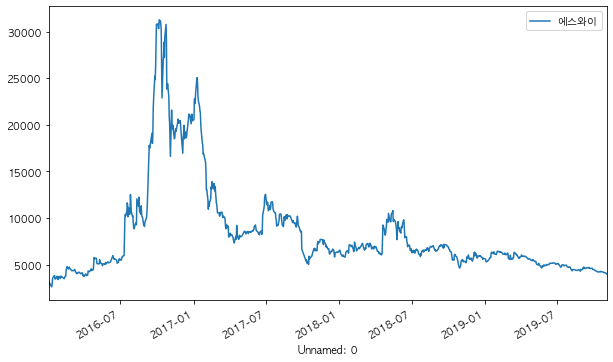

In [34]:
# code = get_company_code()
show_start_end_chart('A109610', '2016-1-1')

In [36]:
price_df = prices
start_date = '2016-6'
initial_money = 100000000

max_profit = 0.5
max_holding_days=365/2
total_pf_df = get_portfolio_backtest_df(get_low_per_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt1 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365/2
# total_pf_df = get_portfolio_backtest_df(get_low_per_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt2 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365*2
# total_pf_df = get_portfolio_backtest_df(get_high_roa_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt3 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365/2
# total_pf_df = get_portfolio_backtest_df(get_high_roa_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt4 = get_backtest_result_from_pf(total_pf_df, price_df)

# total_pf_df = get_portfolio_backtest_df(get_low_per_kospi_firm_list, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt5 = get_backtest_result_from_pf(total_pf_df, price_df)


>>>>>> initial buy list (20) : 2016-06-01 00:00:00
골프존뉴딘홀딩스(A121440) : 648
부방(A014470) : 920
동양(A001520) : 1461
엠케이전자(A033160) : 547
메가스터디(A072870) : 431
네오위즈홀딩스(A042420) : 321
한국전력공사(A015760) : 82
SK(A034730) : 22
아진산업(A013310) : 838
일성신약(A003120) : 42
화승알앤에이(A013520) : 1312
에스와이(A109610) : 944
포스코엠텍(A009520) : 1886
바른전자(A064520) : 402
동원개발(A013120) : 1106
현대종합상사(A011760) : 193
국일제지(A078130) : 8389
모베이스(A101330) : 1027
교보증권(A030610) : 511
큐로컴(A040350) : 1077


>>>>>> enough profit (에스와이 : A109610) - (10066.0 : 0.9) : 2016-07-13 00:00:00
>>>>>> sell list (1) : 2016-07-13 00:00:00
['A109610']


>>>>>> buy list (1) : 2016-07-13 00:00:00
보광산업(A225530) : 1585


>>>>>> enough profit (보광산업 : A225530) - (11351.0 : 0.84) : 2016-10-04 00:00:00
>>>>>> sell list (1) : 2016-10-04 00:00:00
['A225530']


>>>>>> buy list (1) : 2016-10-04 00:00:00
에스와이(A109610) : 583


>>>>>> enough periods (골프존뉴딘홀딩스 : A121440) - (7750 : 0.01) : 183 days 00:00:002016-12-01 00:00:00
>>>>>> enough periods (부방 : A014470)

>>>>>> enough profit (나노스 : A151910) - (3445 : 0.54) : 2017-12-19 00:00:00
>>>>>> sell list (1) : 2017-12-19 00:00:00
['A151910']


>>>>>> buy list (1) : 2017-12-19 00:00:00
일동홀딩스(A000230) : 819


>>>>>> enough periods (에스에이엠티 : A031330) - (1880 : -0.18) : 185 days 00:00:002018-01-15 00:00:00
>>>>>> sell list (1) : 2018-01-15 00:00:00
['A031330']


>>>>>> buy list (1) : 2018-01-15 00:00:00
APS홀딩스(A054620) : 1558


>>>>>> enough profit (상상인 : A038540) - (15292 : 0.64) : 2018-01-19 00:00:00
>>>>>> sell list (1) : 2018-01-19 00:00:00
['A038540']


>>>>>> buy list (1) : 2018-01-19 00:00:00
BGF(A027410) : 533


>>>>>> enough profit (휴온스글로벌 : A084110) - (73901 : 0.51) : 2018-04-06 00:00:00
>>>>>> sell list (1) : 2018-04-06 00:00:00
['A084110']


>>>>>> buy list (1) : 2018-04-06 00:00:00
제일파마홀딩스(A002620) : 334


>>>>>> enough profit (세원 : A234100) - (2910.0 : 0.52) : 2018-04-19 00:00:00
>>>>>> sell list (1) : 2018-04-19 00:00:00
['A234100']


>>>>>> buy list (1) : 2018-04-19 00:00:00
오리온홀딩스(A

>>>>>> enough profit (효성 : A004800) - (78600 : 0.52) : 2019-03-05 00:00:00
>>>>>> sell list (1) : 2019-03-05 00:00:00
['A004800']


>>>>>> buy list (1) : 2019-03-05 00:00:00
HDC(A012630) : 526


>>>>>> enough periods (BGF : A027410) - (8340.0 : -0.04) : 183 days 00:00:002019-04-09 00:00:00
>>>>>> sell list (1) : 2019-04-09 00:00:00
['A027410']


>>>>>> buy list (1) : 2019-04-09 00:00:00
효성(A004800) : 119


>>>>>> enough profit (아시아나항공 : A020560) - (7280 : 0.65) : 2019-04-15 00:00:00
>>>>>> sell list (1) : 2019-04-15 00:00:00
['A020560']


>>>>>> buy list (1) : 2019-04-15 00:00:00
한신공영(A004960) : 348


>>>>>> enough periods (제일파마홀딩스 : A002620) - (25200 : 0.04) : 185 days 00:00:002019-04-22 00:00:00
>>>>>> sell list (1) : 2019-04-22 00:00:00
['A002620']


>>>>>> buy list (1) : 2019-04-22 00:00:00
SIMPAC(A009160) : 1868


>>>>>> enough periods (오리온홀딩스 : A001800) - (19550 : 0.14) : 183 days 00:00:002019-04-25 00:00:00
>>>>>> sell list (1) : 2019-04-25 00:00:00
['A001800']


>>>>>> buy list

In [21]:
kospi_df = prices[['KOSPI']][start_date:]
kospi_df = kospi_df.fillna(method='bfill')
kospi_df['total_change_rate'] = kospi_df/kospi_df.iloc[0]-1

kosdaq_df = prices[['KOSDAQ']][start_date:]
kosdaq_df = kosdaq_df.fillna(method='bfill')
kosdaq_df['total_change_rate'] = kosdaq_df/kosdaq_df.iloc[0]-1

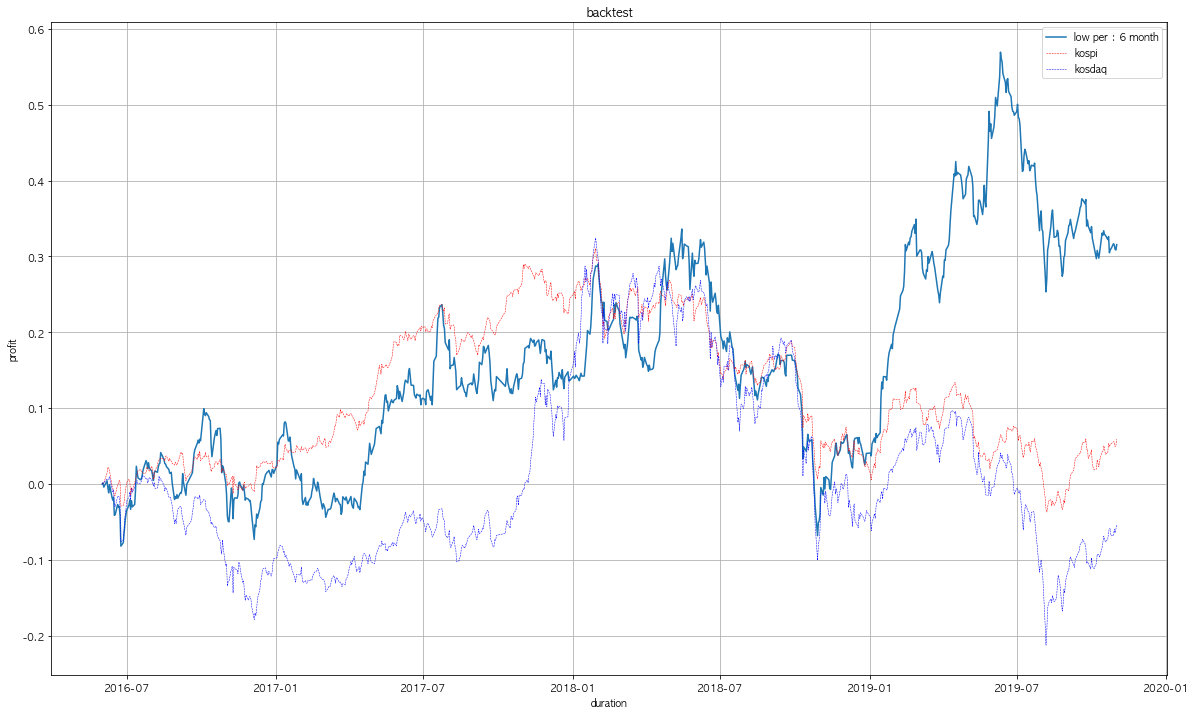

In [22]:
plt.rc('font', size=10)
plt.figure(figsize=(20, 12))
plt.plot(bt1.index, bt1['total_change_rate'], label='low per : 6 month')
# plt.plot(bt2.index, bt2['total_change_rate'], label='low per : 6 month')
# plt.plot(bt3.index, bt3['total_change_rate'], label='high roa : 2 years')
# plt.plot(bt4.index, bt4['total_change_rate'], label='high roa : 6 month')
# plt.plot(bt5.index, bt4['total_change_rate'], label='low per kospi')
plt.plot(kospi_df.index, kospi_df['total_change_rate'], label='kospi', color='red',linewidth=0.5, linestyle='dashed')
plt.plot(kosdaq_df.index, kosdaq_df['total_change_rate'], label='kosdaq', color='blue',linewidth=0.5, linestyle='dashed')
plt.title('backtest')
plt.xlabel("duration")
plt.ylabel("profit")
plt.legend(loc='upper right')
plt.grid()
plt.show()